# kNN

In [3]:
# Imports
import pandas as pd
import numpy as np
import ast
from sklearn.neighbors import NearestNeighbors
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

## Load Data

In [4]:
# Load data
pp_recipes = pd.read_csv("data/PP_recipes_updated.csv")
raw_recipes = pd.read_csv("data/RAW_recipes.csv")

# Merge
recipes = pd.merge(pp_recipes, raw_recipes, how='left', left_on='id', right_on='id')

# Drop unncessary columns
recipes.drop(['name_tokens','ingredient_tokens','steps_tokens',
              'techniques','ingredient_ids','contributor_id',
              'submitted','tags','steps','description', 'ingredients'],
              axis=1,
              inplace=True)

# Format
recipes.insert(0, 'name', recipes.pop('name'))
recipes.insert(4, 'n_ingredients', recipes.pop('n_ingredients'))

## kNN wrt Nutrition Values (and calorie_level, n_ingredients, minutes, n_steps)

In [14]:
# Initialize lists
calories = []
total_fat = []
sugar = []
sodium = []
protein = []
saturated_fat = []
carbs = []

# Append nutrition values
def get_nutrition(recipe):
    calories.append(recipe[0])
    total_fat.append(recipe[1])
    sugar.append(recipe[2])
    sodium.append(recipe[3])
    protein.append(recipe[4])
    saturated_fat.append(recipe[5])
    carbs.append(recipe[6])

# Get nutrition for each recipe
for index, row in recipes.iterrows():
    get_nutrition(ast.literal_eval(row['nutrition']))

# Convert into pandas columns
recipes['calories (#)'] = calories
recipes['total_fat (%DV)'] = total_fat
recipes['sugar (%DV)'] = sugar
recipes['sodium (%DV)'] = sodium
recipes['protein (%DV)'] = protein
recipes['saturated_fat (%DV)'] = saturated_fat
recipes['carbs (%DV)'] = carbs

# Drop nutrition
recipes.drop('nutrition',axis=1,inplace=True)

In [15]:
# Drop columns
X = recipes.drop(['name', 'id', 'technique_names', 'ingredient_names'],axis=1)

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# Fit model
knn = NearestNeighbors(n_neighbors=50, metric='cosine')
knn.fit(X_scaled)

# Find neighbors for "aromatic basmati rice rice cooker"
user_input = recipes.drop(['name', 'id', 'technique_names', 'ingredient_names'],axis=1).iloc[0].values.reshape(1,-1)
user_input_scaled = scaler.transform(user_input)

# Apply knn
distances, indices = knn.kneighbors(user_input_scaled)

# Map indices to original DataFrame
recommended_recipes_by_nutrition = recipes.iloc[indices[0]]

# Display
print("Input: Recipe for Aromatic Basmati Rice Rice Cooker")
recommended_recipes_by_nutrition.head(10)

Input: Recipe for Aromatic Basmati Rice Rice Cooker


,name,id,technique_names,calorie_level,n_ingredients,ingredient_names,minutes,n_steps,calories (#),total_fat (%DV),sugar (%DV),sodium (%DV),protein (%DV),saturated_fat (%DV),carbs (%DV)
0,aromatic basmati rice rice cooker,424415,"['combine', 'drain', 'strain']",0,5,"['basmati rice', 'water', 'salt', 'cinnamon st...",61,6,228.2,2.0,2.0,8.0,9.0,1.0,15.0
23094,brown rice with miso rice cooker,424233,['combine'],0,5,"['miso', 'water', 'fresh gingerroot', 'lemon j...",82,6,245.3,3.0,4.0,13.0,11.0,2.0,16.0
130885,wicklewood s addictive potato salad warm or cold,449473,"['boil', 'drain']",0,5,"['new potato', 'mayonnaise', 'aioli', 'lemon j...",25,6,203.7,4.0,9.0,2.0,9.0,2.0,13.0
60038,kittencal s extra crispy french fries,213744,"['drain', 'fry', 'refrigerate']",0,5,"['water', 'white sugar', 'red potato', 'canola...",1446,6,217.9,0.0,39.0,2.0,10.0,0.0,16.0
8599,potato peel stock,235039,"['boil', 'combine', 'freez', 'refrigerate', 's...",0,5,"['potato', 'onion', 'carrot', 'celery rib', 'w...",75,6,181.0,0.0,13.0,1.0,9.0,0.0,13.0
102010,sweet potatoes from the carolinas,361818,[],0,5,"['olive oil', 'shallot', 'sweet potato', 'fres...",60,6,185.2,5.0,21.0,3.0,7.0,2.0,12.0
1691,yummy mashed potatoes,206349,"['boil', 'drain', 'grate', 'mash']",0,5,"['potato', 'plain yogurt', 'herb-seasoned salt...",17,6,168.7,0.0,8.0,0.0,9.0,1.0,12.0
123261,tequila and lime sweet potatoes,189709,"['boil', 'broil', 'drain', 'grill']",0,5,"['sweet potato', 'fresh lime juice', 'honey', ...",50,6,231.0,0.0,73.0,5.0,7.0,0.0,18.0
21658,marsha s whole wheat pizza,76633,['smooth'],0,5,"['bread flmy', 'whole wheat flmy', 'salt', 'ye...",65,6,215.6,1.0,0.0,12.0,14.0,0.0,14.0
366,pop pop potatoes,342119,"['grill', 'microwave']",0,5,"['potato', 'olive oil', 'dried oregano', 'garl...",60,6,164.0,0.0,6.0,0.0,8.0,0.0,12.0


## kNN wrt Techniques

In [16]:
# Convert to lists
recipes['technique_names'] = recipes['technique_names'].apply(ast.literal_eval)

# Extract unique values
unique_values = set(item for sublist in recipes['technique_names'] for item in sublist)
unique_list = list(unique_values)

# Perform one-hot encoding
for category in unique_list:
    recipes[category] = recipes['technique_names'].apply(lambda x: 1 if category in x else 0)

In [17]:
# Drop columns
X = recipes.drop(['name', 'id', 'technique_names', 'ingredient_names',
                  'calorie_level', 'n_ingredients', 'minutes', 'n_steps',
                  'calories (#)', 'sugar (%DV)', 'sodium (%DV)', 'protein (%DV)',
                  'saturated_fat (%DV)','carbs (%DV)'],axis=1)

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# Fit model
knn = NearestNeighbors(n_neighbors=50, metric='cosine')
knn.fit(X_scaled)

# Find neighbors for "aromatic basmati rice rice cooker"
user_input = recipes.drop(['name', 'id', 'technique_names', 'ingredient_names',
                  'calorie_level', 'n_ingredients', 'minutes', 'n_steps',
                  'calories (#)', 'sugar (%DV)', 'sodium (%DV)', 'protein (%DV)',
                  'saturated_fat (%DV)','carbs (%DV)'],
                  axis=1).iloc[0].values.reshape(1,-1)
user_input_scaled = scaler.transform(user_input)

# Apply knn
distances, indices = knn.kneighbors(user_input_scaled)

# Map indices to original DataFrame
recommended_recipes_by_techniques = recipes.iloc[indices[0]]

# Display
print("Input: Recipe for Aromatic Basmati Rice Rice Cooker")
recommended_recipes_by_techniques.head(10)

Input: Recipe for Aromatic Basmati Rice Rice Cooker


,name,id,technique_names,calorie_level,n_ingredients,ingredient_names,minutes,n_steps,calories (#),total_fat (%DV),...,smoke,simmer,whisk,crush,slow cook,pressure cook,strain,scramble,soak,combine
0,aromatic basmati rice rice cooker,424415,"[combine, drain, strain]",0,5,"['basmati rice', 'water', 'salt', 'cinnamon st...",61,6,228.2,2.0,...,0,0,0,0,0,0,1,0,0,1
38761,easy horseradish mustard sauce,71038,"[combine, drain, strain]",0,4,"['horseradish', 'dijon mustard', 'sour cream',...",2,3,42.9,6.0,...,0,0,0,0,0,0,1,0,0,1
2558,ultimate tuna salad sandwiches,282672,"[combine, drain, strain]",1,9,"['tuna in water', 'braggs liquid amino', 'mayo...",10,6,297.6,9.0,...,0,0,0,0,0,0,1,0,0,1
55977,danablu tomatoes,427642,"[combine, drain, strain]",0,7,"['tomato', 'golden delicious apple', 'green ol...",20,16,148.8,14.0,...,0,0,0,0,0,0,1,0,0,1
55747,easy weeknight chili,292352,"[combine, drain, strain]",2,5,"['refried bean', 'salsa', 'sweet corn', 'chili...",10,3,776.7,44.0,...,0,0,0,0,0,0,1,0,0,1
125244,cherry bombs,132132,"[bake, combine, drain, strain]",0,9,"['flmy', 'baking powder', 'baking soda', 'salt...",45,11,90.1,5.0,...,0,0,0,0,0,0,1,0,0,1
150934,cucumber raita cucumber salad,482735,"[drain, strain]",0,8,"['cucumber', 'plain yogurt', 'cumin', 'paprika...",5,14,89.7,6.0,...,0,0,0,0,0,0,1,0,0,0
33056,cucumber dill salad with feta cheese,171510,"[drain, strain]",0,8,"['english cucumber', 'salt', 'scallion', 'oliv...",25,9,119.1,14.0,...,0,0,0,0,0,0,1,0,0,0
171816,cracked pepper lemon pasta,103397,"[drain, strain]",2,7,"['pastum', 'olive oil', 'garlic clove', 'lemon...",10,9,519.4,20.0,...,0,0,0,0,0,0,1,0,0,0
95926,zucchini pizza casserole,435750,"[bake, combine, drain, strain]",1,10,"['zucchini', 'salt', 'egg', 'parmesan cheese',...",40,16,455.1,42.0,...,0,0,0,0,0,0,1,0,0,1


## Cosine Similarity with Ingredients

Note: TF-IDF is not suitable for best model performance. Need to find a way to use ingredients in a better way. So either:
- One Hot Encoding for each available ingredient
- Reduce ingredients into its parent term (e.g. basmati rice -> rice)

In [18]:
# Step 1: TF-IDF on ingredients
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(recipes['ingredient_names'])

In [ ]:
# Step 1.5: Find out frequency of words
feature_names = tfidf.get_feature_names_out()
dense_tfidf = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(dense_tfidf, columns=feature_names)

# Find freqs
word_frequencies = tfidf_df.sum(axis=0)
word_frequencies = word_frequencies / len(tfidf_df)
word_frequencies = word_frequencies.sort_values(ascending=False)

# Put into df
word_freqs = pd.DataFrame({"word": list(word_frequencies.index), "pct": list(word_frequencies.values)})

word_freqs

,word,pct
0,pepper,0.062862
1,salt,0.059475
2,sugar,0.054812
3,butter,0.047186
4,fresh,0.045871
...,...,...
2683,tac,0.000002
2684,tic,0.000002
2685,sashimi,0.000002
2686,grade,0.000002


In [20]:
# Step 2: Define a function to recommend similar recipes
def recommend_recipes(user_ingredients, top_n=3):
    # Vectorize the user input
    user_vector = [1 if ingredient in user_ingredients else 0 for ingredient in tfidf.get_feature_names_out()] #mlb.classes_]

    # Compute cosine similarity between user input and all recipes
    similarities = cosine_similarity([user_vector], tfidf_matrix)[0]

    # Get indices of top N similar recipes
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Return the top recommended recipes
    return recipes.iloc[top_indices][['name', 'ingredient_names']]

# Step 3: Example user input
user_input = ['basmati rice', 'water', 'salt', 'cinnamon stick', 'green cardamom pod',
              'rice', 'cinnamon','cardamom']  # <-- Inserted general ingredients names

# Step 4: Get top 50 recipe recommendations
recommended_recipes_by_ingredients = recommend_recipes(user_input, top_n=50)

print("Recommended Recipes:")
recommended_recipes_by_ingredients.head(10)

## Dimension Reduction on ingredients

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
df = recipes[['name','ingredient_names']]

# Vectorize ingredients using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
ingredient_matrix = tfidf.fit_transform(df['ingredient_names'])

# Standardize the data
scaler = StandardScaler()
ingredient_matrix_scaled = scaler.fit_transform(ingredient_matrix.toarray())

TFIDF returns a shape of (178265,2688) where (n_recipes, n_features).

### PCA

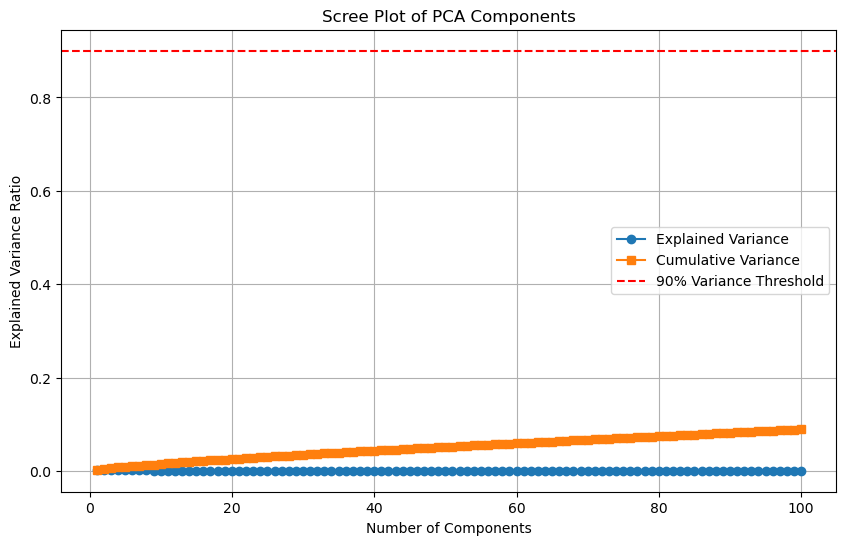

In [ ]:
# Apply PCA on 100 components
pca = PCA(n_components=100)  # By default, all components are included
ingredient_pca = pca.fit_transform(ingredient_matrix_scaled)

# Scree Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='s', label='Cumulative Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title('Scree Plot of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid()
plt.show()

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', method='exact')
ingredient_tsne = tsne.fit_transform(ingredient_matrix_scaled)

t-SNE did not yield good results as the data has too many dimensions

### TruncatedSVD

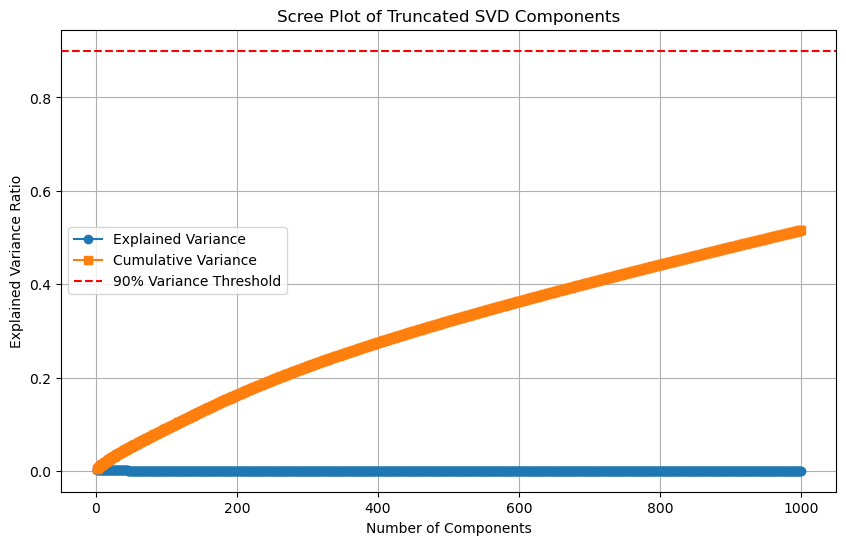

In [7]:
from sklearn.decomposition import TruncatedSVD

# Apply TruncatedSVD on 1000 components
tsvd = TruncatedSVD(n_components=1000)
ingredient_tsvd = tsvd.fit_transform(ingredient_matrix_scaled)

# Scree plot
explained_variance_ratio = tsvd.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='s', label='Cumulative Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title('Scree Plot of Truncated SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid()
plt.show()

## Find top recipes by position in all models

### By simple count

In [ ]:
# Step 1: Combine all values from the DataFrames into one list
from typing import Counter

all_values = pd.concat([recommended_recipes_by_nutrition,
                        recommended_recipes_by_techniques,
                        recommended_recipes_by_ingredients])['name'].tolist()

# Step 2: Count the frequency of each value
value_counts = Counter(all_values)

# Step 3: Convert the Counter to a DataFrame
count_df = pd.DataFrame(value_counts.items(), columns=['value', 'count']).sort_values(by='count', ascending=False).reset_index(drop=True)

# Display
final_recommendations = list(count_df['value'].head(11))
recipes[recipes['name'].isin(final_recommendations)]

,name,id,technique_names,calorie_level,n_ingredients,ingredient_names,minutes,n_steps,calories (#),total_fat (%DV),...,smoke,simmer,whisk,crush,slow cook,pressure cook,strain,scramble,soak,combine
0,aromatic basmati rice rice cooker,424415,"[combine, drain, strain]",0,5,"['basmati rice', 'water', 'salt', 'cinnamon st...",61,6,228.2,2.0,...,0,0,0,0,0,0,1,0,0,1
1796,quickie sweet rice,414896,"[boil, simmer]",0,5,"['rice', 'water', 'brown sugar', 'raisin', 'ci...",28,6,228.9,0.0,...,0,1,0,0,0,0,0,0,0,0
29398,low fat cinnamon rolls,121419,"[bake, knead]",0,5,"['flmy', 'baking powder', 'salt', 'water', 'ci...",40,6,141.5,0.0,...,0,0,0,0,0,0,0,0,0,0
34410,ruby red rocket cocktail,286409,"[combine, strain]",0,5,"['vodka', 'triple sec', 'ruby red grapefruit j...",5,6,143.5,0.0,...,0,0,0,0,0,0,1,0,0,1
53394,perfect crock pot rice,16465,"[pour, slow cook]",0,4,"['rice', 'salt', 'water', 'butter']",155,3,175.5,0.0,...,0,0,0,0,1,0,0,0,0,0
73486,easy rice pudding,51640,"[bake, boil, simmer, thicken]",0,8,"['rice', 'water', 'egg', 'sugar', 'raisin', 'm...",75,13,213.1,8.0,...,0,1,0,0,0,0,0,0,0,0
82325,rice with milk,194263,"[blend, boil, drain, simmer]",1,6,"['water', 'salt', 'rice', 'milk', 'sugar', 'ci...",30,9,358.7,10.0,...,0,1,0,0,0,0,0,0,0,0
105735,garlic rosemary mashed potato martini,131928,"[combine, strain]",0,4,"['vodka', 'dry vermouth', 'garlic-stuffed olif...",5,5,139.0,0.0,...,0,0,0,0,0,0,1,0,0,1
119953,witchypoo,188019,"[combine, strain]",0,4,"['chocolate liqueur', 'white chocolate liqueur...",2,3,104.6,0.0,...,0,0,0,0,0,0,1,0,0,1
119960,arclight cinemas martini,321923,"[combine, strain]",2,5,"['rum', 'blue curacao', 'pineapple juice', 'sp...",2,3,621.7,0.0,...,0,0,0,0,0,0,1,0,0,1


### By weighted count

In [40]:
# Step 1: Define a function to assign rank-based weights
def assign_weights(df):
    # Assign weights based on position (higher for earlier rows)
    n = len(df)
    weights = {value: n - idx for idx, value in enumerate(df['name'])}
    return weights

# Step 2: Apply the function to each DataFrame
nutrition_weights = assign_weights(recommended_recipes_by_nutrition)
techniques_weights = assign_weights(recommended_recipes_by_techniques)
ingredients_weights = assign_weights(recommended_recipes_by_ingredients)

# Step 3: Apply scaling factors to tweak the weights
nutrition_scaling_factor = 1      # Keep nutrition_scaling_factor as is
techniques_scaling_factor = 0.5   # Reduce techniques_scaling_factor by half
ingredients_scaling_factor = 1.5  # Increase ingredients_scaling_factor by 1.5

# Step 4: Scale the weights by multiplying each value
scaled_nutrition_weights = {key: value * nutrition_scaling_factor for key, value in nutrition_weights.items()}
scaled_techniques_weights = {key: value * techniques_scaling_factor for key, value in techniques_weights.items()}
scaled_ingredients_weights = {key: value * ingredients_scaling_factor for key, value in ingredients_weights.items()}

# Step 5: Combine all weight dictionaries
combined_weights = Counter(scaled_nutrition_weights) + Counter(scaled_techniques_weights) + Counter(scaled_ingredients_weights)

# Step 6: Convert to DataFrame and sort
score_df = pd.DataFrame(combined_weights.items(), columns=['name', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

# Display
final_recommendations = list(score_df['name'].head(11))
recipes[recipes['name'].isin(final_recommendations)]

,name,id,technique_names,calorie_level,n_ingredients,ingredient_names,minutes,n_steps,calories (#),total_fat (%DV),...,smoke,simmer,whisk,crush,slow cook,pressure cook,strain,scramble,soak,combine
0,aromatic basmati rice rice cooker,424415,"[combine, drain, strain]",0,5,"['basmati rice', 'water', 'salt', 'cinnamon st...",61,6,228.2,2.0,...,0,0,0,0,0,0,1,0,0,1
1796,quickie sweet rice,414896,"[boil, simmer]",0,5,"['rice', 'water', 'brown sugar', 'raisin', 'ci...",28,6,228.9,0.0,...,0,1,0,0,0,0,0,0,0,0
14487,sweet rice with cinnamon roz mafooar,427321,"[boil, simmer, steam]",0,6,"['rice', 'water', 'salt', 'butter', 'powdered ...",30,7,243.2,12.0,...,0,1,0,0,0,0,0,0,0,0
51032,abby s rice pudding,201890,[simmer],0,5,"['white rice', 'water', 'whole milk', 'sugar',...",90,5,138.1,4.0,...,0,1,0,0,0,0,0,0,0,0
53394,perfect crock pot rice,16465,"[pour, slow cook]",0,4,"['rice', 'salt', 'water', 'butter']",155,3,175.5,0.0,...,0,0,0,0,1,0,0,0,0,0
67611,rice for dummies and in the microwave too,167828,"[microwave, steam, strain]",0,4,"['rice', 'water', 'olive oil', 'salt']",25,8,205.3,5.0,...,0,0,0,0,0,0,1,0,0,0
73486,easy rice pudding,51640,"[bake, boil, simmer, thicken]",0,8,"['rice', 'water', 'egg', 'sugar', 'raisin', 'm...",75,13,213.1,8.0,...,0,1,0,0,0,0,0,0,0,0
81215,egyptian rice for fish,145824,[boil],1,5,"['rice', 'oil', 'onion', 'water', 'salt']",30,3,366.0,0.0,...,0,0,0,0,0,0,0,0,0,0
82325,rice with milk,194263,"[blend, boil, drain, simmer]",1,6,"['water', 'salt', 'rice', 'milk', 'sugar', 'ci...",30,9,358.7,10.0,...,0,1,0,0,0,0,0,0,0,0
125558,light oven baked brown rice,427100,"[bake, boil, pour]",0,4,"['rice', 'water', 'olive oil', 'salt']",60,8,188.8,2.0,...,0,0,0,0,0,0,0,0,0,0
